<a href="https://colab.research.google.com/github/stebechoi/CP2/blob/YJ/MF_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv("/content/drive/MyDrive/CP2/ml-100k/u.data",names=r_cols, sep='\t',encoding='latin-1')
ratings = ratings[['user_id','movie_id','rating']].astype(int) #timestamp 제거

In [4]:
u_cols = ['user_id','age','sex','occupation','zip_code']
users = pd.read_csv('/content/drive/MyDrive/CP2/ml-100k/u.user',sep='\|',names=u_cols,encoding='latin-1')
users = users[['user_id','occupation']]

<ipython-input-4-248bf55a84de>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('/content/drive/MyDrive/CP2/ml-100k/u.user',sep='\|',names=u_cols,encoding='latin-1')


# **MF 기본 알고리즘**

In [5]:
class MF():
  def __init__(self, ratings,K,alpha,beta,iterations,verbose=True):
    self.R = np.array(ratings)
    self.num_users, self.num_items = np.shape(self.R)
    self.K = K
    self.alpha = alpha
    self.beta = beta
    self.iterations = iterations
    self.verbose = verbose

  def rmse(self):
    xs, ys = self.R.nonzero()
    #평점이 있는(0이 아닌) 요소의 인덱스를 가져온다
    self.predictions = []
    self.errors = []
    for x,y in zip(xs,ys):
      prediction = self.get_prediction(x,y)
      self.predictions.append(prediction)
      self.errors.append(self.R[x,y]-prediction)
    self.predictions = np.array(self.predictions)
    self.errors = np.array(self.errors)
    
    return np.sqrt(np.mean(self.errors**2))

  #정해진 반복 횟수만큼 
  def train(self):
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users,self.K))
    #p행렬을 임의의 값으로 채움. 여기서는 평균 0, 표준편차 1/K 인 정규분포를 갖는 난수로 초기화
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items,self.K))

    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])

    rows, columns = self.R.nonzero()
    self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows, columns)]

    training_process=[]
    for i in range(self.iterations):
      np.random.shuffle(self.samples)
      self.sgd()
      rmse = self.rmse()
      training_process.append((i+1, rmse))
      if self.verbose:
        if (i+1)%10 ==0:
          print("Iteration: %d ; Train RMSE = %.4f" % (i+1,rmse))
    return training_process

  #평점 예측값을 구하는 함수. b는 평균 bu는 사용자 bias bd는 아이템 bias
  def get_prediction(self,i,j):
    prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
    return prediction

  def sgd(self):
    for i,j,r in self.samples:
      prediction = self.get_prediction(i,j)
      e = (r - prediction)

      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
      self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

      self.P[i,:] += self.alpha * (e*self.Q[j,:] - self.beta*self.P[i,:])
      self.Q[j,:] += self.alpha * (e*self.P[i,:] - self.beta*self.Q[j,:])




In [6]:
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)

In [7]:
train_process=mf.train()

Iteration: 10 ; Train RMSE = 0.9585
Iteration: 20 ; Train RMSE = 0.9374
Iteration: 30 ; Train RMSE = 0.9281
Iteration: 40 ; Train RMSE = 0.9226
Iteration: 50 ; Train RMSE = 0.9185
Iteration: 60 ; Train RMSE = 0.9146
Iteration: 70 ; Train RMSE = 0.9101
Iteration: 80 ; Train RMSE = 0.9040
Iteration: 90 ; Train RMSE = 0.8953
Iteration: 100 ; Train RMSE = 0.8836


In [8]:
# R = np.array(ratings)
# rows, columns = R.nonzero()
# samples = [(i,j,R[i,j]) for i,j in zip(rows, columns)]
# R.nonzero()

In [9]:
# samples = [(i,j, R[i,j]) for i,j in zip(rows, columns)]

In [10]:
# for i, j, r in samples:
#   print(j)

# **Train/Test 분리**

In [11]:
from sklearn.utils import shuffle
train_size = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(train_size*len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [15]:
class MF2():
  def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
    self.R = np.array(ratings)
    self.num_users, self.num_items = np.shape(self.R)
    self.K = K
    self.alpha = alpha
    self.beta = beta
    self.iterations = iterations
    self.verbose = verbose
    #사용자와 아이템의 인덱스를 매핑해줌. pivot으로 만든 데이터프레임을 변수로 넣어줄예정
    item_id_index = []
    index_item_id = []
    for i, one_id in enumerate(ratings):
      item_id_index.append([one_id, i])
      index_item_id.append([i, one_id])
    self.item_id_index = dict(item_id_index)
    self.index_item_id = dict(index_item_id)
    user_id_index = []
    index_user_id = []
    for i, one_id in enumerate(ratings.T):
      user_id_index.append([one_id, i])
      index_user_id.append([i, one_id])
    self.user_id_index = dict(user_id_index)
    self.index_user_id = dict(index_user_id)

    self.test_matrix = np.zeros((self.num_users, self.num_items))
    for row in ratings_test.itertuples():
        self.test_matrix[row[1]-1, row[2]-1] = row[3]

  def rmse(self):
    xs, ys = self.R.nonzero()
    #평점이 있는(0이 아닌) 요소의 인덱스를 가져온다
    self.predictions = []
    self.errors = []
    for x,y in zip(xs,ys):
      prediction = self.get_prediction(x,y)
      self.predictions.append(prediction)
      self.errors.append(self.R[x,y]-prediction)
    self.predictions = np.array(self.predictions)
    self.errors = np.array(self.errors)
    
    return np.sqrt(np.mean(self.errors**2))
  
  def set_test(self, ratings_test):
    test_set = []
    for i in range(len(ratings_test)):
      x = self.user_id_index[ratings_test.iloc[i,0]]
      y = self.item_id_index[ratings_test.iloc[i,1]]
      z = ratings_test.iloc[i,2]
      test_set.append([x,y,z])
      self.R[x,y] = 0
    self.test_set = test_set
    return test_set

  def test_rmse(self):
    error = 0
    for one_set in self.test_set:
      predicted = self.get_prediction(one_set[0], one_set[1])
      error += pow(one_set[2] - predicted, 2)
    return np.sqrt(error/len(self.test_set))

  def test(self):
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users,self.K))
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items,self.K))

    self.b_u = np.zeros(self.num_users)
    self.b_d = np.zeros(self.num_items)
    self.b = np.mean(self.R[self.R.nonzero()])

    rows, columns = self.R.nonzero()
    self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows, columns)]

    training_process=[]
    for i in range(self.iterations):
      np.random.shuffle(self.samples)
      self.sgd()
      rmse1 = self.rmse()
      rmse2 = self.test_rmse()
      training_process.append((i+1, rmse1, rmse2))
      if self.verbose:
        if (i+1)%10 ==0:
          print("Iteration: %d ; Train RMSE = %.4f; Test RMSE = %.4f" % (i+1,rmse1, rmse2))
    return training_process


  def get_one_prediction(self, user_id, item_id):
    return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

  def full_prediction(self):
    return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)

  def sgd(self):
    for i,j,r in self.samples:
      prediction = self.get_prediction(i,j)
      e = (r - prediction)

      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
      self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

      self.P[i,:] += self.alpha * (e*self.Q[j,:] - self.beta*self.P[i,:])
      self.Q[j,:] += self.alpha * (e*self.P[i,:] - self.beta*self.Q[j,:])

  def get_prediction(self,i,j):
    prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
    return prediction

  def precision(self, k=5):
    predict_matrix = self.full_prediction()
    top_k_indices = np.argsort(-predict_matrix, axis=1)[:, :k]

    precision_list = []
    for i in range(self.num_users):
        true_items = np.where(self.test_matrix[i, :] > 0)[0]
        predicted_items = top_k_indices[i]
        precision_k = precision_score(np.isin(predicted_items, true_items), np.ones(k))
        precision_list.append(precision_k)

    avg_precision_k = np.mean(precision_list)
    print('Precision@{}: {:.4f}'.format(k, avg_precision_k))



In [16]:
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

mf = MF2(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration: 10 ; Train RMSE = 0.9659; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9410; Test RMSE = 0.9644
Iteration: 30 ; Train RMSE = 0.9298; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9230; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9183; Test RMSE = 0.9496
Iteration: 60 ; Train RMSE = 0.9143; Test RMSE = 0.9477
Iteration: 70 ; Train RMSE = 0.9105; Test RMSE = 0.9463
Iteration: 80 ; Train RMSE = 0.9063; Test RMSE = 0.9449
Iteration: 90 ; Train RMSE = 0.9011; Test RMSE = 0.9434
Iteration: 100 ; Train RMSE = 0.8944; Test RMSE = 0.9415


In [17]:
mf.precision(k=5)

Precision@5: 0.0477




---



---



---



In [ ]:
# num_users = ratings_train['user_id'].nunique()
# num_items = ratings_train['movie_id'].nunique()
# train_matrix = np.zeros((num_users, num_items))
# for row in ratings_train.itertuples():
#     train_matrix[row[1]-1, row[2]-1] = row[3]

In [ ]:
# train_matrix = np.zeros((943,1641))

In [ ]:
# R2 = ratings_train.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
# R2

In [ ]:
# predicted_matrix

In [ ]:
# ratings.user_id.nunique()

In [ ]:
# test_matrix = np.zeros((943, 1682))
# for row in ratings_test.itertuples():
#     test_matrix[row[1]-1, row[2]-1] = row[3]

# test_matrix

In [ ]:
# np.argsort(predicted_matrix, axis=1)

In [ ]:
# ratings_test[(ratings_test.user_id == 91)]

In [ ]:
# test_set[0:5]

In [ ]:
# ratings_test

In [ ]:
# len(item_id_index)

In [ ]:
# R = np.array(ratings)

In [ ]:
# item_id_index = []
# index_item_id = []
# for i, one_id in enumerate(ratings):
#       item_id_index.append([one_id, i])
#       index_item_id.append([i, one_id])
# item_id_index = dict(item_id_index)
# index_item_id = dict(index_item_id)  

In [ ]:
# index_item_id

In [ ]:
# user_id_index = []
# index_user_id = []
# for i, one_id in enumerate(ratings.T):
#   user_id_index.append([one_id, i])
#   index_user_id.append([i, one_id])
# user_id_index = dict(user_id_index)
# index_user_id = dict(index_user_id)

# **MF 기본 신경망**

In [18]:
from sklearn.utils import shuffle

train_size = 0.8

ratings = shuffle(ratings,random_state=2)
cutoff = int(train_size*len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

K = 200
mu = ratings_train.rating.mean()
M = ratings.user_id.max() +1
N = ratings.movie_id.max() +1

def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

user = Input(shape=(1,))
item = Input(shape=(1,))
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias =  Embedding(N,1,embeddings_regularizer=l2())(item)

R = layers.dot([P_embedding, Q_embedding], axes=2)
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)

model = Model(inputs=[user,item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [20]:
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values],
    y=ratings_train.rating.values -mu,
    epochs=50,
    batch_size=256,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values -mu
    )
)


Epoch 1/50
313/313 [==============================] - 4s 9ms/step - loss: 5.2638 - RMSE: 1.1228 - val_loss: 5.0127 - val_RMSE: 1.1298
Epoch 2/50
313/313 [==============================] - 2s 6ms/step - loss: 4.7744 - RMSE: 1.1207 - val_loss: 4.5536 - val_RMSE: 1.1279
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 4.3426 - RMSE: 1.1185 - val_loss: 4.1485 - val_RMSE: 1.1260
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 3.9619 - RMSE: 1.1172 - val_loss: 3.7911 - val_RMSE: 1.1243
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 3.6260 - RMSE: 1.1155 - val_loss: 3.4758 - val_RMSE: 1.1228
Epoch 6/50
313/313 [==============================] - 3s 9ms/step - loss: 3.3295 - RMSE: 1.1141 - val_loss: 3.1976 - val_RMSE: 1.1213
Epoch 7/50
313/313 [==============================] - 2s 8ms/step - loss: 3.0680 - RMSE: 1.1126 - val_loss: 2.9522 - val_RMSE: 1.1200
Epoch 8/50
313/313 [==============================] - 3s 8ms

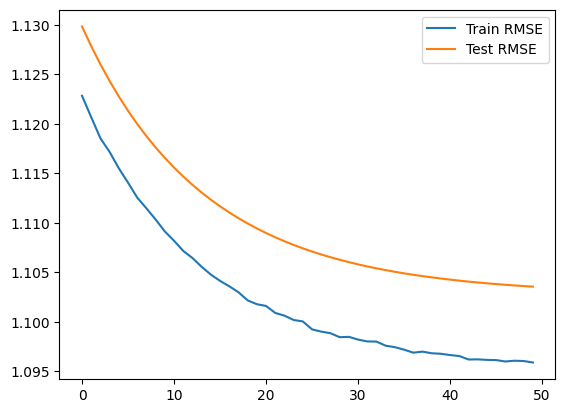

In [21]:
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.legend()
plt.show()

In [22]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids,movie_ids]) + mu

ratings_test[0:6]
predictions

1/1 [==============================] - 0s 181ms/step


array([[3.7447832],
       [3.51559  ],
       [3.503773 ],
       [3.580076 ],
       [3.5009828],
       [3.4599352]], dtype=float32)

# **MF 신경망 은닉층 추가, occupation 변수 추가**

In [23]:
def RMSE2(y_true,y_pred):
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)


625/625 [==============================] - 1s 2ms/step


1.1013691285349083

In [24]:
occupation={}
def convert_occ(x):
  if x in occupation:
    return occupation[x]
  else:
    occupation[x] = len(occupation)
    return occupation[x]

users['occupation'] = users['occupation'].apply(convert_occ)
users

,user_id,occupation
0,1,0
1,2,1
2,3,2
3,4,0
4,5,1
...,...,...
938,939,5
939,940,4
940,941,5
941,942,11


In [25]:
L = len(occupation)

In [26]:
user = Input(shape=(1,))
item = Input(shape=(1,))
occ = Input(shape=(1,))
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)
occ_embedding = Embedding(L,3, embeddings_regularizer=l2())(occ)
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias =  Embedding(N,1,embeddings_regularizer=l2())(item)

#Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation
#concatenate를 위해서 1차원으로 줄임
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
occ_layer = Flatten()(occ_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)
R = Concatenate()([P_embedding, Q_embedding,user_bias, item_bias,occ_layer])

R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item, occ], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       188800      ['input_3[0][0]']                
                                                                                            

In [27]:
train_occ = pd.merge(ratings_train,users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test,users, on='user_id')['occupation']

In [29]:
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
    y = ratings_train.rating.values - mu,
    epochs = 50,
    batch_size=512,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/50
 12/157 [=>............................] - ETA: 14s - loss: 2.1070 - RMSE: 1.0787

KeyboardInterrupt: ignored

In [ ]:
plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.legend()
plt.show()